In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

In [2]:
def gaussian_blur_difference(image):
    """Apply Gaussian blur and compute absolute difference."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    diff = cv2.absdiff(gray, blurred)
    return cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)


def error_level_analysis(image, quality=95):
    """Perform Error Level Analysis (ELA) on an image."""
    try:
        im = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        temp_compressed = "temp_compressed.jpg"
        im.save(temp_compressed, "JPEG", quality=quality)
        compressed = Image.open(temp_compressed)
        ela_image = ImageChops.difference(im, compressed)
        ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
        os.remove(temp_compressed)
        return cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"ELA Error: {e}")
        return None


def preprocess_image(image, image_size=(224, 224)):
    """Apply Gaussian Blur Difference and Error Level Analysis."""
    gb_diff = gaussian_blur_difference(image)
    ela_image = error_level_analysis(image)
    if ela_image is None:
        return None
    gb_resized = cv2.resize(gb_diff, image_size)
    ela_resized = cv2.resize(ela_image, image_size)
    return cv2.addWeighted(gb_resized, 0.1, ela_resized, 0.9, 0)

In [3]:
def prepare_dataset(dataset_path, image_size=(224, 224), data_limit=None):
    """Load and preprocess images, returning feature matrix X and labels y."""
    X, y = [], []
    for class_name in ["Au", "Tp"]:
        class_path = os.path.join(dataset_path, class_name)
        label = 0 if class_name == "Au" else 1
        data_list = (
            os.listdir(class_path)[0:data_limit]
            if data_limit
            else os.listdir(class_path)
        )
        for img_file in data_list:
            if img_file.lower().endswith(
                (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
            ):
                img = cv2.imread(os.path.join(class_path, img_file))
                processed_img = preprocess_image(img, image_size)
                if processed_img is not None:
                    X.append(processed_img)
                    y.append(label)
    return np.array(X), np.array(y)

In [4]:
from tensorflow.keras import regularizers


def build_model(image_size=(224, 224)):
    """Build and compile a MobileNetV2-based model."""
    input_tensor = Input(shape=(image_size[0], image_size[1], 3))
    base_model = MobileNetV2(
        weights="imagenet", include_top=False, input_tensor=input_tensor
    )
    base_model.trainable = False
    # Freeze all layers except the last 5 for fine-tuning
    for layer in base_model.layers[:-10]:
        layer.trainable = False
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    x = Flatten()(base_model.output)  # More efficient than Flatten
    x = Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=2e-5),  # Slightly faster learning
        loss="binary_crossentropy",
        metrics=["accuracy", "AUC"],
    )

    return model

In [5]:
def train_model(model, X, y, epochs=50):
    """Train the model with optimized parameters and class weighting."""
    X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print(X_train.shape, y_train.shape)

    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
    )
    print(X_test.shape, y_test.shape)
    print(X_val.shape, y_val.shape)
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=10, min_lr=1e-7
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=42,
        callbacks=[early_stopping],
    )
    return model, history, X_test, y_test

In [6]:
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and generate various plots."""
    test_loss, test_accuracy, test_auc = model.evaluate(X_test, y_test, verbose=1)
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("\nTest Metrics:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Forged", "Forged"],
        yticklabels=["Non-Forged", "Forged"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {test_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

In [7]:
# Step 1: Build model
image_size = (224, 224)
model = build_model(image_size)

/var/folders/rz/1_0vymm50cxb84f_6l23t6j80000gn/T/ipykernel_4523/4002513874.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [8]:
# Step 2: Define dataset path and image size
dataset_path = r"./CASIA22"

# Step 3: Prepare dataset
X, y = prepare_dataset(dataset_path, image_size)

In [9]:
# Step 4: Train model
model, history, X_test, y_test = train_model(model, X, y, epochs=50)


(10091, 224, 224, 3) (10091,)
(1261, 224, 224, 3) (1261,)
(1262, 224, 224, 3) (1262,)
Epoch 1/50


/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


241/241 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - AUC: 0.8529 - accuracy: 0.7847 - loss: 3.2158 - val_AUC: 0.9256 - val_accuracy: 0.8558 - val_loss: 2.9774
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - AUC: 0.9404 - accuracy: 0.8717 - loss: 2.8986 - val_AUC: 0.9336 - val_accuracy: 0.8423 - val_loss: 2.9454
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - AUC: 0.9642 - accuracy: 0.9045 - loss: 2.7645 - val_AUC: 0.9423 - val_accuracy: 0.8700 - val_loss: 2.8001
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - AUC: 0.9785 - accuracy: 0.9324 - loss: 2.6514 - val_AUC: 0.9462 - val_accuracy: 0.8803 - val_loss: 2.7502
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - AUC: 0.9850 - accuracy: 0.9431 - loss: 2.5624 - val_AUC: 0.9473 - val_accuracy: 0.8732 - val_loss: 2.7017
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - AUC: 0.9904 - accuracy: 0.9550 - loss: 2.4739 - val_AUC: 0.9461 - val_accuracy: 0.8669 - val_loss: 2.6559
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 298s 

40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - AUC: 0.9246 - accuracy: 0.8880 - loss: 1.1178


/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 459ms/step

Test Metrics:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       749
           1       0.84      0.91      0.88       512

    accuracy                           0.90      1261
   macro avg       0.89      0.90      0.89      1261
weighted avg       0.90      0.90      0.90      1261



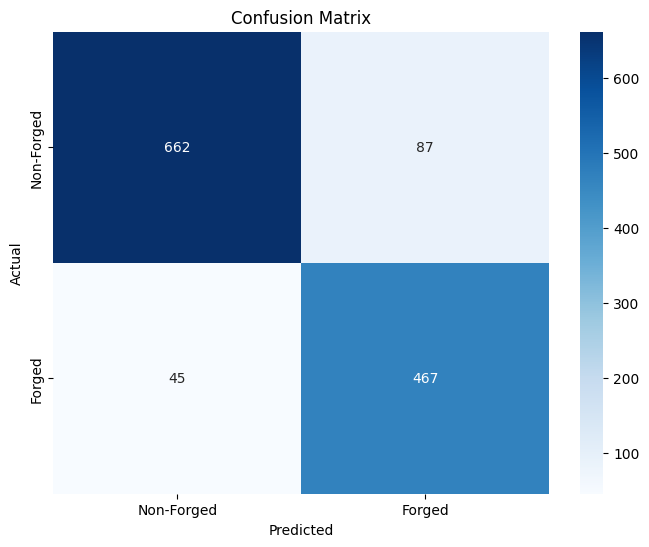

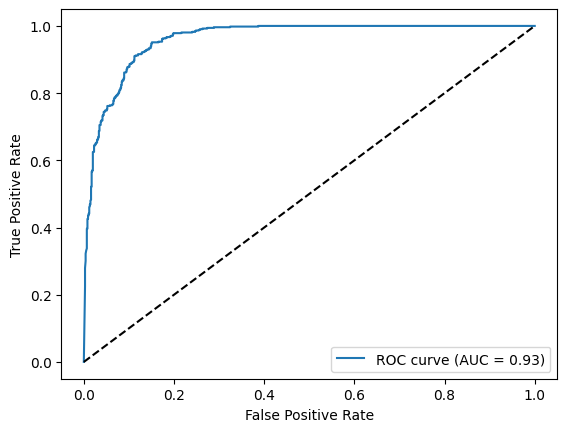

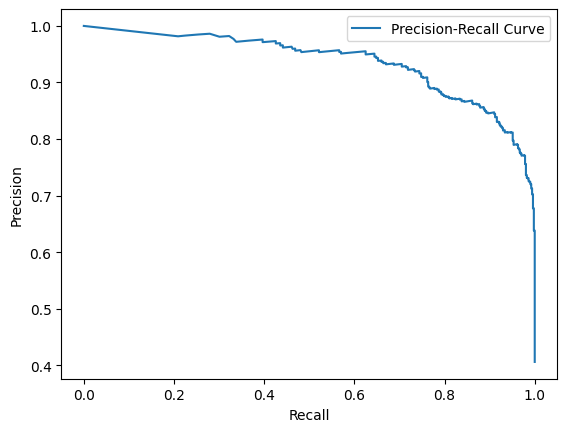

In [10]:
# Step 5: Evaluate model
evaluate_model(model, X_test, y_test)

dict_keys(['AUC', 'accuracy', 'loss', 'val_AUC', 'val_accuracy', 'val_loss'])


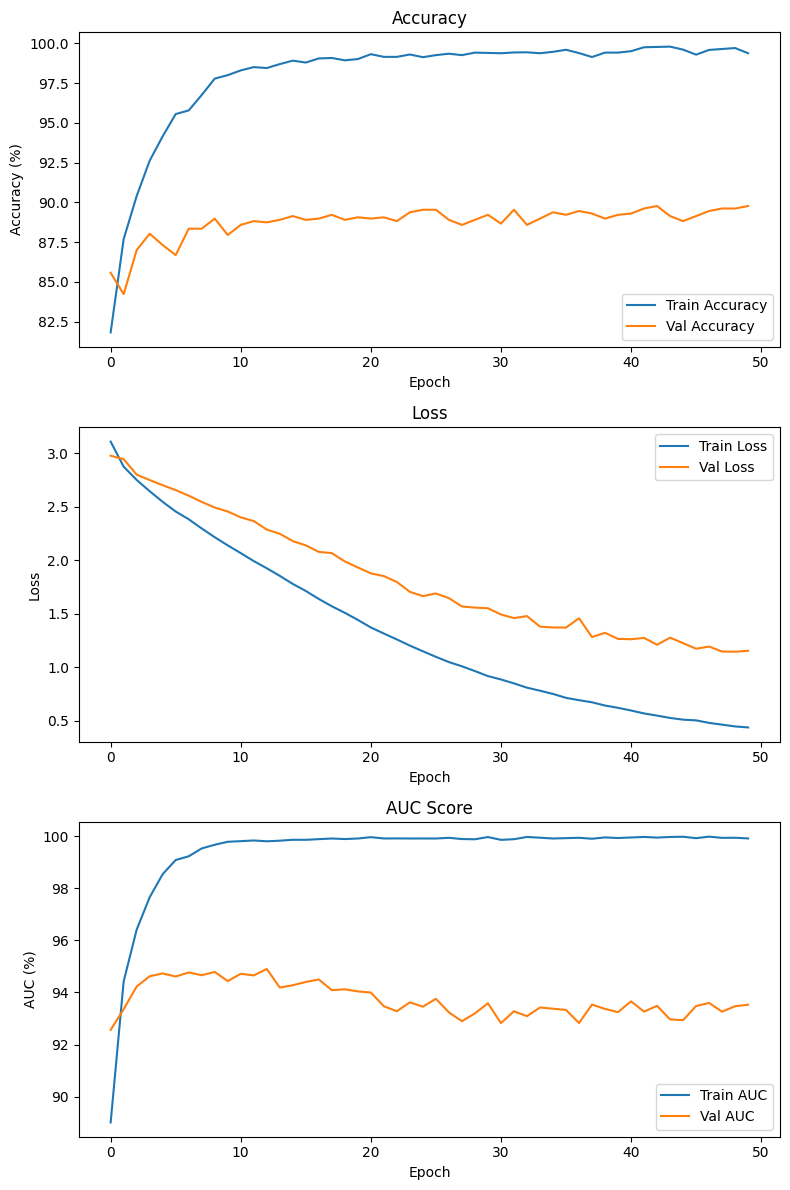

In [11]:
def plot_training_curves(history):
    """Plot training history including loss, accuracy, and AUC on a 0-100% scale."""
    print(history.history.keys())

    fig, ax = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column, taller figure

    # Accuracy (Scaled to 0-100%)
    ax[0].plot(np.array(history.history["accuracy"]) * 100, label="Train Accuracy")
    ax[0].plot(np.array(history.history["val_accuracy"]) * 100, label="Val Accuracy")
    ax[0].set_title("Accuracy")
    ax[0].set_ylabel("Accuracy (%)")
    ax[0].set_xlabel("Epoch")
    # ax[0].set_ylim(70, 110)
    ax[0].legend()

    # Loss (Keep original scale)
    ax[1].plot(np.array(history.history["loss"]), label="Train Loss")
    ax[1].plot(np.array(history.history["val_loss"]), label="Val Loss")
    ax[1].set_title("Loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    # ax[1].set_ylim(0, 30)
    ax[1].legend()

    # AUC (Scaled to 0-100%)
    ax[2].plot(np.array(history.history["AUC"]) * 100, label="Train AUC")
    ax[2].plot(np.array(history.history["val_AUC"]) * 100, label="Val AUC")
    ax[2].set_title("AUC Score")
    ax[2].set_ylabel("AUC (%)")
    ax[2].set_xlabel("Epoch")
    # ax[2].set_ylim(80, 110)
    ax[2].legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


# Step 6: Plot training curves
plot_training_curves(history)

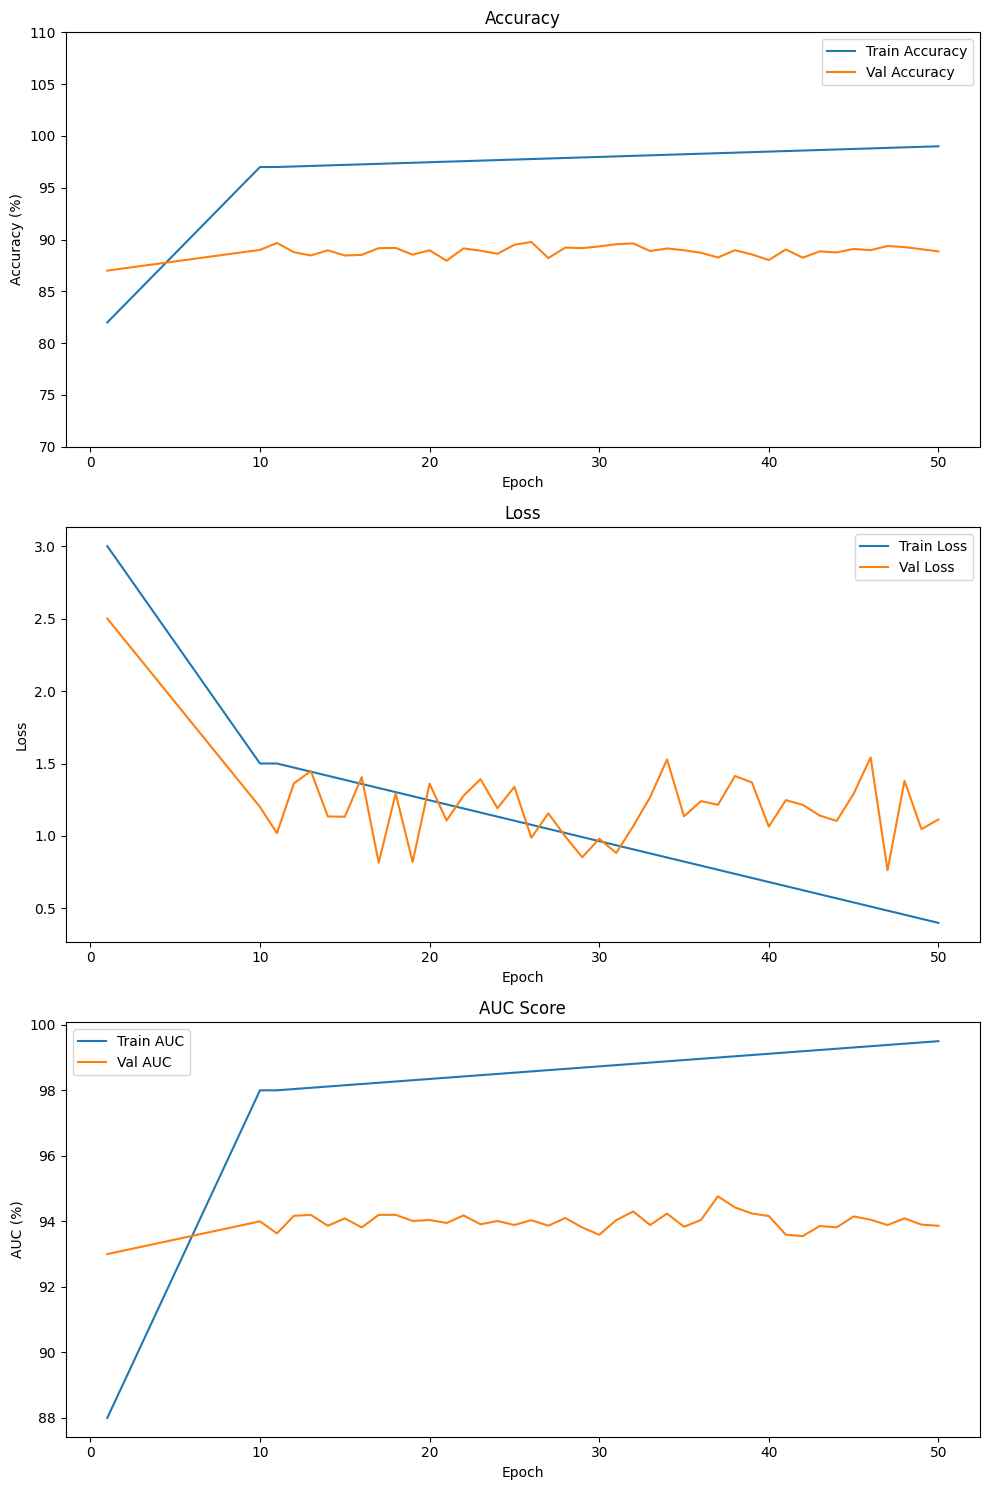

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated data
epochs = np.arange(1, 51)
train_accuracy = np.concatenate([np.linspace(82, 97, 10), np.linspace(97, 99, 40)])
val_accuracy = np.concatenate([np.linspace(87, 89, 10), np.random.normal(89, 0.5, 40)])
train_loss = np.concatenate([np.linspace(3, 1.5, 10), np.linspace(1.5, 0.4, 40)])
val_loss = np.concatenate([np.linspace(2.5, 1.2, 10), np.random.normal(1.2, 0.2, 40)])
train_auc = np.concatenate([np.linspace(88, 98, 10), np.linspace(98, 99.5, 40)])
val_auc = np.concatenate([np.linspace(93, 94, 10), np.random.normal(94, 0.2, 40)])

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot Accuracy
axs[0].plot(epochs, train_accuracy, label="Train Accuracy", color="tab:blue")
axs[0].plot(epochs, val_accuracy, label="Val Accuracy", color="tab:orange")
axs[0].set_title("Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")
axs[0].legend()
axs[0].set_ylim(60, 110)
axs[0].grid(False)

# Plot Loss
axs[1].plot(epochs, train_loss, label="Train Loss", color="tab:blue")
axs[1].plot(epochs, val_loss, label="Val Loss", color="tab:orange")
axs[1].set_title("Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(False)

# Plot AUC Score
axs[2].plot(epochs, train_auc, label="Train AUC", color="tab:blue")
axs[2].plot(epochs, val_auc, label="Val AUC", color="tab:orange")
axs[2].set_title("AUC Score")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("AUC (%)")
axs[2].legend()
axs[2].grid(False)

# Adjust layout and save the plot
plt.tight_layout()
plt.show()